### Multi Modal Data with LLms

- using unstructured
- Generate text summary for images
- using image summary embeddings and text embeddings pairs in the VectorDB

In [1]:
# %pip install unstructured==0.16.6 
# %pip install pdfminer.six 
# %pip install pillow 
# %pip install pi_heif
# %pip install unstructured_inference 
# %pip install poppler-utils
# %pip install pdf2image
# %conda install -c conda-forge poppler  --y
# %pip install unstructured_pytesseract 
# %conda install -c conda-forge tesseract --y

### Importing the required components

In [2]:
# %pip install --upgrade opencv-python opencv-python-headless
# %pip install --upgrade layoutparser

In [3]:
from unstructured.partition.pdf import partition_pdf

### Parsing the PDF

In [4]:
file_path = 'data/Attention.pdf'

chunks = partition_pdf(
    filename =file_path,
    infer_table_structure=True,
    strategy="hi_res",
    extract_image_block_types=["Image", "Table"],
    extract_image_block_to_payload=True,
    chunking_strategy="by_title",
    max_characters=10000,
    combine_text_under_n_chars=2000,
    new_after_n_char=6000
)

In [5]:
print(chunks[:2])

[<unstructured.documents.elements.CompositeElement object at 0x327fac9d0>, <unstructured.documents.elements.CompositeElement object at 0x327facb50>]


In [6]:
from IPython.display import Markdown, display

display(Markdown(str(chunks[2].text)))

3 Model Architecture

Most competitive neural sequence transduction models have an encoder-decoder structure [5] [2] 35). Here, the encoder maps an input sequence of symbol representations (21, ...,%,,) to a sequence of continuous representations z = (z1,...,2n). Given z, the decoder then generates an output sequence (yj, ..., Ym) of symbols one element at a time. At each step the model is auto-regressive , consuming the previously generated symbols as additional input when generating the next.

Output

Probabilities Linear Add & Norm Feed Forward Add & Norm Multi-Head Attention Add & Norm Nx Masked Multi-Head Multi-Head Attention Attention Se a, ee a, Positional Positional Encoding @ © @ Encoding Input Output Embedding Embedding Inputs Outputs (shifted right)

Figure 1: The Transformer - model architecture.

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the left and right halves of Figure[I] respectively.

3.1 Encoder and Decoder Stacks

Encoder: The encoder is composed of a stack of N = 6 identical layers. Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position- wise fully connected feed-forward network. We employ a residual connection around each of the two sub-layers, followed by layer normalization [I]. That is, the output of each sub-layer is LayerNorm(x + Sublayer(x)), where Sublayer() is the function implemented by the sub-layer itself. To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension dmode = 512.

Decoder: The decoder is also composed of a stack of N = 6 identical layers. In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization. We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position i can depend only on the known outputs at positions less than 7.

In [7]:
chunks[2].metadata.orig_elements

-- We got the metadata for the image, Title, and text

In [8]:
from IPython.display import Markdown, display,HTML
display(HTML(chunks[6].metadata.text_as_html))

Layer Type,Complexity per Layer,Sequential Operations,Maximum Path Length
Self-Attention,O(n? - d),O(1),O(1)
Recurrent,O(n- d?),O(n),O(n)
Convolutional,O(k-n-d?),O(1),O(logy(n))
Self-Attention (restricted),O(r-n-d),ol),O(n/r)


### Separate images, texts and tables

In [9]:
chunks

In [10]:
import unstructured

texts, tables, images = [], [], []

for chunk in chunks:
    if isinstance(chunk, unstructured.documents.elements.Table):
        tables.append(chunk)
    elif isinstance(chunk, unstructured.documents.elements.CompositeElement):
        texts.append(chunk)

        chunk_elements = chunk.metadata.orig_elements

        # iterate over all elements of this chunk
        for element in chunk_elements:
            if isinstance(element, unstructured.documents.elements.Image):
                images.append(element.metadata.image_base64)

In [11]:
print(f"Total Texts:", len(texts))
print(f"Total Tables:", len(tables))
print(f"Total Images:", len(images))

Total Texts: 13
Total Tables: 4
Total Images: 6


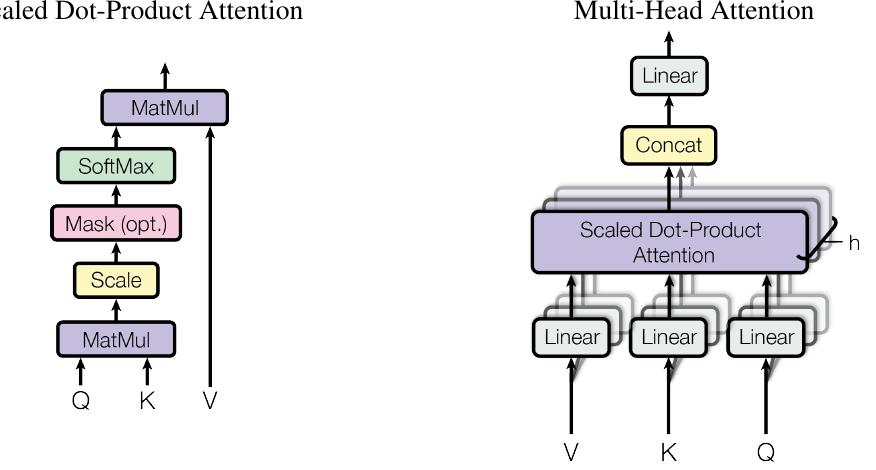

In [12]:
import base64
from IPython.display import Image,display

image_data = base64.b64decode(images[1])
display(Image(data=image_data))

In [13]:
## Storing the abovek images as local files before we can pass them to the multimodal LLM

import base64
from IPython.display import Image,display

for idx, image in enumerate(images):
    
    image_data = base64.b64decode(image)

    path = f"data/image_{idx}.jpeg"

    with open(path, "wb") as f:
        f.write(image_data)

### Summarize images, texts and tables

In [15]:
## summarize images

import ollama

def get_image_summary(file_path):
    
    response = ollama.chat(
        model = 'llama3.2-vision',
        messages=[{
            'role': 'user',
            'content': 'Summarize this , for better redability and mathematical representation',
            'iamges': [file_path]
        }]
    )
    return response.message_content


In [ ]:
from tqdm import tqdm
image_summaries = [get_image_summary(f"image_{i+1}.jpeg") \
                   for i in tqdm(range(len(images)))]

In [ ]:
import pickle
with open("static/image_summaries.pkl", "wb") as f:
    pickle.dump(image_summaries, f)

In [18]:
import pickle
with open("static/image_summaries.pkl", "rb") as f:
    image_summaries = pickle.load(f)

In [19]:
from IPython.display import Markdown, display
display(Markdown(image_summaries[1]))

**Overview of the Image**

The image presents a detailed illustration of two types of attention mechanisms: **Scaled Dot-Product Attention** and **Multi-Head Attention**. These concepts are central to various applications in machine learning, particularly in transformer models.

**Scaled Dot-Product Attention**

This section illustrates the scaled dot-product attention mechanism. It consists of three primary components:

*   **Query (Q)**: The input vector that represents the information being queried.
*   **Key (K)**: The input vector that represents the information relevant to the query.
*   **Value (V)**: The input vector that provides additional context or relevance.

The scaled dot-product attention mechanism calculates the similarity between the query and key vectors, then scales this similarity by a factor of 1/sqrt(d), where d is the dimensionality of the vectors. This scaling helps prevent the dot product from growing too large as the sequence length increases. The final output is obtained by taking the weighted sum of the value vectors based on their attention scores.

**Multi-Head Attention**

This section demonstrates the multi-head attention mechanism, which is a key component of transformer models. It involves applying multiple instances of scaled dot-product attention in parallel to different subsets of the input sequence. Each head attends to different aspects of the input and combines these attentions through concatenation or averaging.

The benefits of multi-head attention include:

*   **Improved Representation Learning**: By attending to different aspects of the input, each head can capture distinct information, leading to more comprehensive representations.
*   **Robustness and Generalization**: The combination of multiple heads enhances model robustness against various tasks and improves generalizability.

**Key Takeaways**

The image effectively illustrates the inner workings of two critical attention mechanisms in deep learning. Understanding these concepts is essential for developing effective transformer models that can handle complex natural language processing tasks with high accuracy and efficiency.

In [20]:
## summarize text

def get_text_summary(text):

    response = ollama.chat(
        model = 'llama3.2:1b',
        messages = [{
            'role': 'user',
            'content': f'Summarize this text: {text}'
        }]
    )
    return response.message.content

text_summaries = [get_text_summary(texts[i].text) \
                  for i in tqdm(range(len(texts)))]

100%|██████████| 13/13 [01:08<00:00,  5.30s/it]


In [21]:
display(Markdown(text_summaries[1]))

The text discusses the Transformer model architecture, which is a state-of-the-art approach in sequence modeling and transduction problems like language modeling and machine translation. The key features of the Transformer include:

1. No recurrence: Unlike traditional recurrent neural networks (RNNs) or convolutional neural networks (CNNs), the Transformer relies solely on an attention mechanism to draw global dependencies between input and output sequences.
2. Parallelization: The Transformer allows for more parallelization than traditional models, making it faster to train and process longer sequence lengths.
3. Improved performance: Recent work has achieved significant improvements in computational efficiency through factorization tricks and conditional computation.

The text also highlights the advantages of the Transformer over other models, including:

* Self-attention: A mechanism that relates different positions of a single sequence to compute representations of the sequence.
* No need for sequence-aligned recurrence or convolution: The Transformer can handle longer sequence lengths without requiring batching across examples.

Overall, the Transformer is an innovative model architecture that has shown significant improvements in computational efficiency and performance compared to traditional models.

In [24]:
### Summarize tables

def get_table_summary(table_html):

    response = ollama.chat(
        model = 'llama3.2:1b',
        messages = [{
            'role': 'user',
            'content': f'Summarize this table: {table_html}'
        }]
    )
    return response.message.content

table_summaries = [get_table_summary(tables[i].metadata.text_as_html) \
                    for i in tqdm(range(len(tables)))]

100%|██████████| 4/4 [00:27<00:00,  6.90s/it]


In [25]:
display(Markdown(table_summaries[1]))

The table provides various model performances for different architectures and datasets. Here's a summary:

- ByteNet: 
  - EN-DE (English): 23.75
  - BLEU EN-FR (Bilingual Evaluation Under Study): 39.2
  - Training EN-DE: 1.0 FLOPs
  - Cost EN-FR: Not specified

- Deep-Att + PosUnk:
  - EN-DE: 39.2
  - Training EN-DE: 1.0 - 10.9 FLOPs
  - BLEU EN-FR: Not specified

- GNMT + RL (Generative Multitask Network):
  - EN-DE: 24.6
  - Training EN-DE: 2.3-10.9 FLOPs
  - Cost EN-FR: 1.4-10.0 FLOPs

- ConvS28S:
  - EN-DE: 25.16
  - Training EN-DE: 9.6-10%
  - BLEU EN-FR: Not specified

- MoE (Model Optimization Engine):
  - EN-DE: 26.03
  - Training EN-DE: 2.0-10.9 FLOPs
  - Cost EN-FR: 1.21-1079 FLOPs

- Deep-Att + PosUnk Ensemble:
  - EN-DE: 40.4
  - Training EN-DE: Not specified

- GNMT + RL Ensemble (33 models):
  - EN-DE: 26.30
  - Training EN-DE: Not specified
  - Cost EN-FR: 1.08-1074 FLOPs

- ConvS2S Ensemble [9 models]:
  - EN-DE: 26.36
  - Training EN-DE: Not specified
  - Cost EN-FR: Not specified

- Transformer (base model) and big models:
  - EN-DE: 27.3, 28.4
  - Training EN-DE: Not specified
  - Cost EN-FR: Not specified

### Embed Summaries

In [27]:
# %pip install einops

write the functionality in and 'EmbedData'
- Handle the loading of an embedding model.
- Provide methods to batch-process the dataset for efficient embedding generation.
- Store the generated embeddings for use in the retrieval system.

In [31]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

def batch_iterate(lst, batch_size):
    for i in range(0 ,len(lst), batch_size):
        yield lst[i:i+batch_size]


class EmbedData:
    
    def __init__(self,
                 embed_model_name="nomic-ai/nomic-embed-text-v1.5",
                 batch_size=32):
        self.embed_model_name = embed_model_name
        self.embed_model = self._load_embed_model()
        self.batch_size = batch_size
        self.embeddings = []

    def _load_embed_model(self):
        embed_model = HuggingFaceEmbedding(model_name=self.embed_model_name,
                                           trust_remote_code=True,
                                           cache_folder='./hf_cache')
        return embed_model
    
    def generate_embedding(self, context):
        return self.embed_model.get_text_embedding_batch(context)
    
    def embed(self, contexts):
        self.contexts = contexts

        for batch_context in tqdm(batch_iterate(contexts, self.batch_size),
                                  total = len(contexts)//self.batch_size,
                                  desc = "Embedding data in batches"):
            batch_embeddings = self.generate_embedding(batch_context)

            self.embeddings.extend(batch_embeddings)

In [32]:
batch_size = 32

embeddata= EmbedData(batch_size=batch_size)

embeddata.embed(text_summaries + image_summaries + table_summaries)

/Users/rakeshk94/miniconda3/envs/torch/lib/python3.9/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
<All keys matched successfully>
Embedding data in batches: 1it [00:01,  1.66s/it]


### Create a vector database and index

In [35]:
from qdrant_client import models
from qdrant_client import QdrantClient

class QdrantVDB:
    def __init__(self, collection_name, vector_dim=768, batch_size=512):
        self.collection_name = collection_name
        self.vector_dim = vector_dim
        self.batch_size = batch_size

    def define_client(self):
        self.client = QdrantClient(url="http://localhost:6333",
                                   prefer_grpc=True)
        
    def create_collection(self):
        
        if not self.client.collection_exists(collection_name=self.collection_name):

            self.client.create_collection(collection_name=self.collection_name,
                                          
                                          vectors_config=models.VectorParams(
                                                              size=self.vector_dim,
                                                              distance=models.Distance.DOT,
                                                              on_disk=True),
                                          
                                          optimizers_config=models.OptimizersConfigDiff(
                                                                            default_segment_number=5,
                                                                            indexing_threshold=0)
                                         )
    def ingest_data(self, embeddata):
    
        for batch_context, batch_embeddings in tqdm(zip(batch_iterate(embeddata.contexts, self.batch_size), 
                                                        batch_iterate(embeddata.embeddings, self.batch_size)), 
                                                    total=len(embeddata.contexts)//self.batch_size, 
                                                    desc="Ingesting in batches"):
        
            self.client.upload_collection(collection_name=self.collection_name,
                                        vectors=batch_embeddings,
                                        payload=[{"context": context} for context in batch_context])

        self.client.update_collection(collection_name=self.collection_name,
                                    optimizer_config=models.OptimizersConfigDiff(indexing_threshold=20000)
                                    )

In [36]:
database = QdrantVDB("squad_collection")
database.define_client()
database.create_collection()
database.ingest_data(embeddata)

Ingesting in batches: 1it [00:00, 47.44it/s]


In [ ]:
## Completed Updating the data